![](StrokePrediction.jpeg)

# 1. Read the Data

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate, validation_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn import tree

import graphviz

from xgboost import XGBClassifier

import optuna

from scipy import stats
from scipy.stats import kurtosis, skew

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from time import time

import shap

from warnings import simplefilter
simplefilter("ignore")

In [6]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [25]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 5110 rows and 12 columns.


#### Null and duplicate values

In [27]:
print(f'The dataset has {data.isna().sum().sum()} null values.')

The dataset has 201 null values.


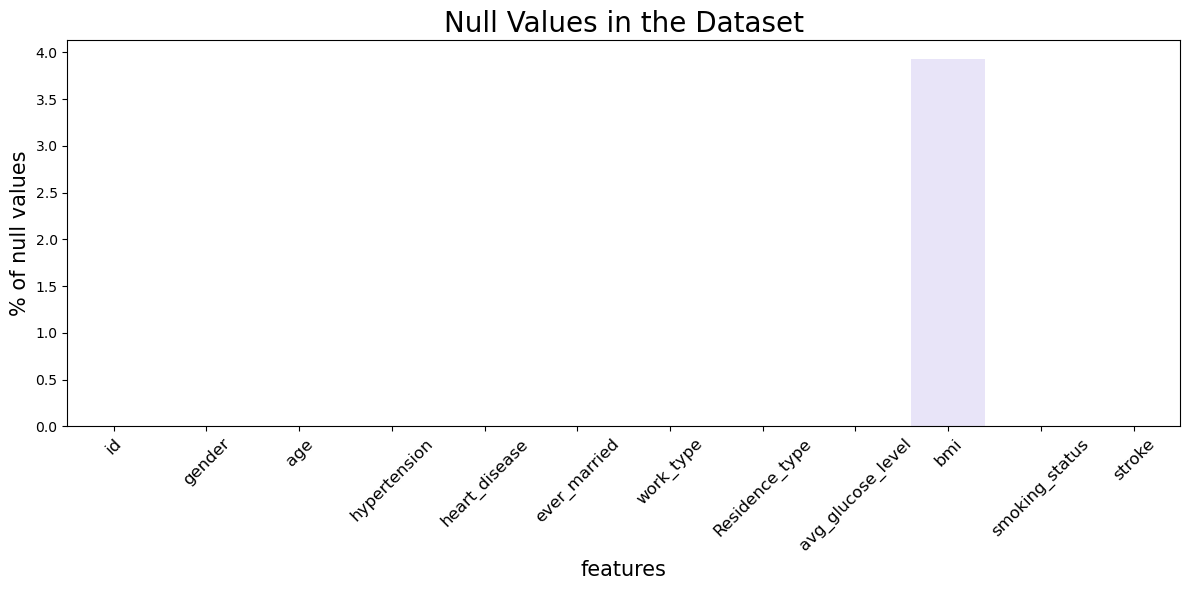

In [29]:
def plot_nulls(data, title, x_axis_label, y_axis_label):
    
    # number of nulls for each column
    data_nulls = (data.apply(lambda x: x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    plt.figure(figsize=(12,6))
    sns.barplot(data_nulls, x="index", y="count", alpha=0.3)
    
    plt.title(title, fontsize=20)
    plt.xlabel(x_axis_label, fontsize=15)
    plt.xticks(rotation=45, fontsize=12)
    plt.ylabel(y_axis_label, fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
plot_nulls(data,"Null Values in the Dataset", 'features', '% of null values')  

All the null values are in the 'bmi' column. They are the 4% of the total 'bmi' values. Given that this is not a very high percentage, I will have to decide whether to impute these nulls or to simply drop the corresponding rows.

In [34]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataset.')

There are 0 duplicate rows in the dataset.


#### Data types, basic stats and cardinality

In [36]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

These are the data types. Apparently, they agree with the corresponding type of features. Therefore, there is no need to convert the columns.

I want to check whether all the IDs are different or whether there are multiple entries corresponding to the same patient.

In [38]:
print(f'The total number of entries (rows) is {len(data)}.')

print(f'The total number of different IDs is {data.id.nunique()}.')

The total number of entries (rows) is 5110.
The total number of different IDs is 5110.


Given that the two number coincide, each entry corresponds to a different patient.

Let's have a look at the categorical features cardinality.

In [40]:
cat_features = [col for col in data.columns if data[col].dtypes == 'O']

print(f'feature           cardinality')
for cat in cat_features:
    print('{:22s} {:2s}'.format(cat, str(data[cat].nunique())))

feature           cardinality
gender                 3 
ever_married           2 
work_type              5 
Residence_type         2 
smoking_status         4 


All the features have low cardinality. This means that they can be dealt with encoding without major issues.

In [42]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The min and max values of the numerical features seem reasonable. There are neither negative nor 'infinite' (i.e. veary large) values.

# 2. Exploratory Data Analysis

## 2.1 Overview¶

I am having a look at all the variables distributions.

<Figure size 1200x600 with 0 Axes>

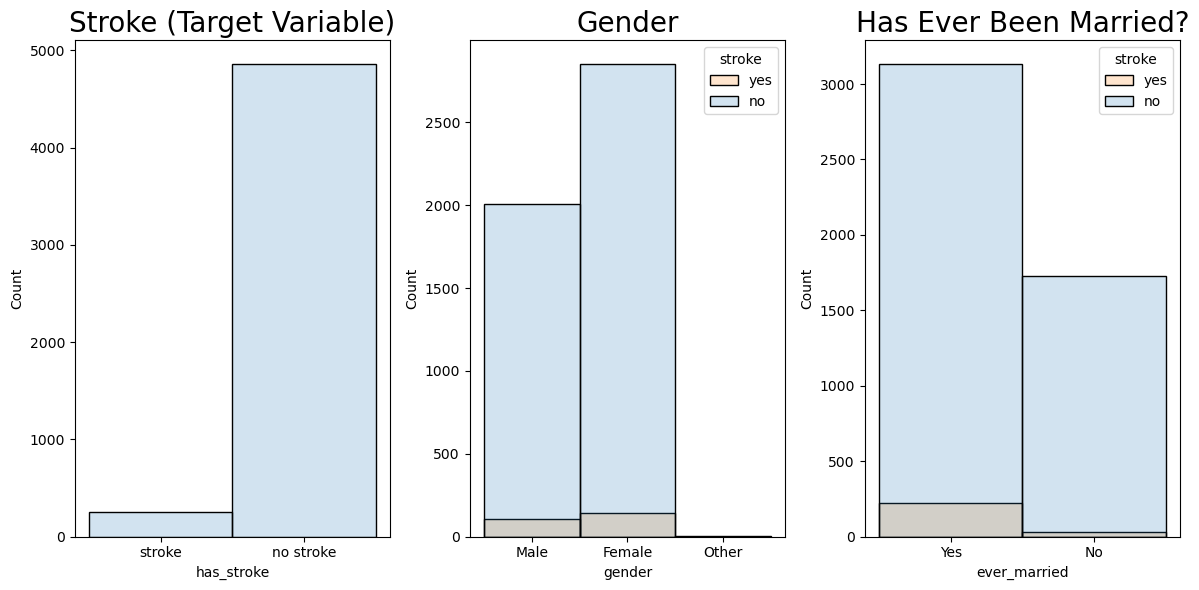

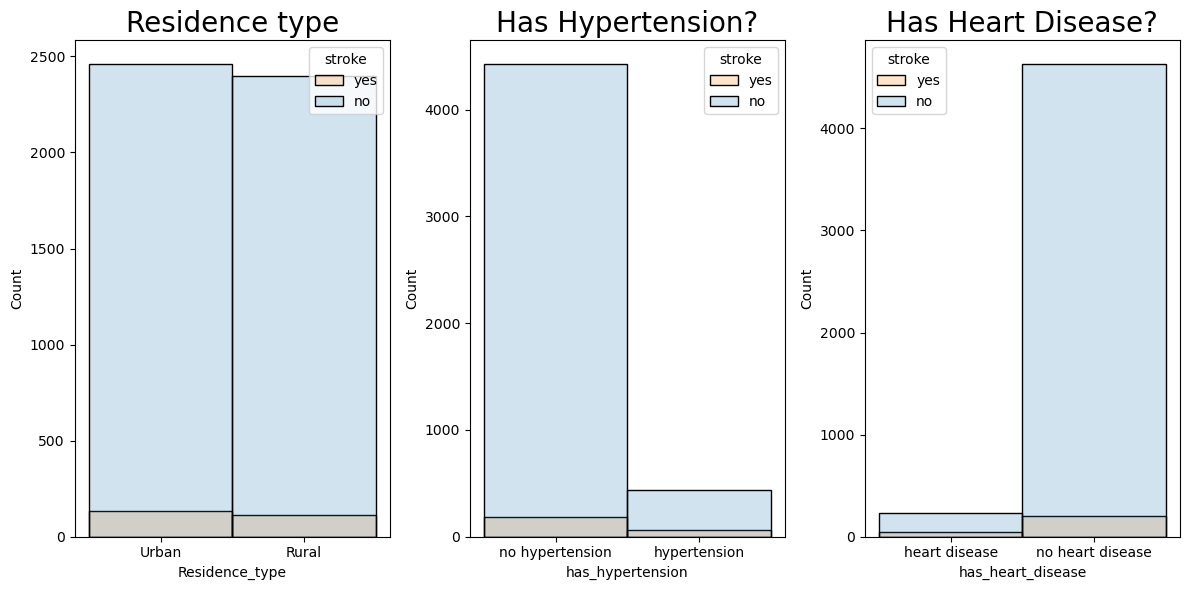

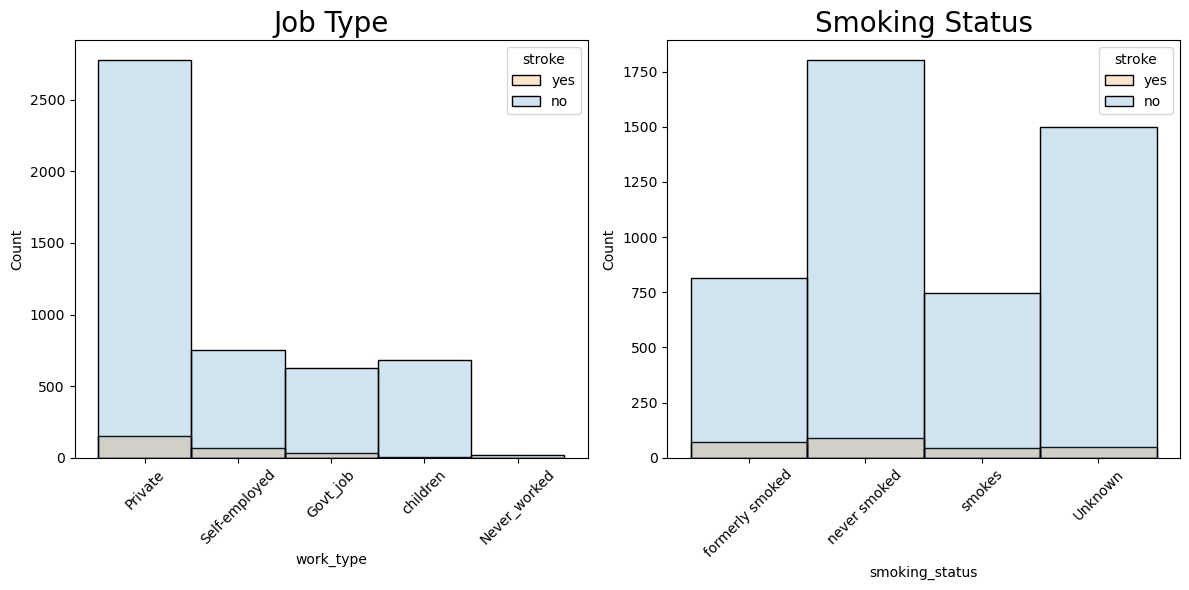

In [58]:
has_stroke = {0:'no stroke', 1:'stroke'}
data['has_stroke'] = data['stroke'].map(has_stroke)

has_hypertension = {1:'hypertension', 0:'no hypertension'}
data['has_hypertension'] = data['hypertension'].map(has_hypertension)

has_heart_disease = {1:'heart disease', 0:'no heart disease'}
data['has_heart_disease'] = data['heart_disease'].map(has_heart_disease)


### Figures ###
bigfig = plt.figure(figsize=(12,6))

(top, central, bottom) = bigfig.subfigures(3,1)

### Top figure ###
top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

ax1 = sns.histplot(data=data, x='has_stroke', alpha=0.2, ax=ax1)
ax1.set_title('Stroke (Target Variable)', size=20)

ax2 = sns.histplot(data=data, x='gender', hue='stroke', alpha=0.2, ax=ax2)
ax2.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax2.set_title('Gender', size=20)

ax3 = sns.histplot(data=data, x='ever_married', hue='stroke', alpha=0.2, ax=ax3)
ax3.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax3.set_title('Has Ever Been Married?', size=20)

plt.tight_layout()

### Central figure ###
central.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

ax1 = sns.histplot(data=data, x='Residence_type', hue='stroke', alpha=0.2, ax=ax1)
ax1.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax1.set_title('Residence type', size=20)

ax2 = sns.histplot(data=data, x='has_hypertension', hue='stroke', alpha=0.2, ax=ax2)
ax2.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax2.set_title('Has Hypertension?', size=20)

ax3 = sns.histplot(data=data, x='has_heart_disease', hue='stroke', alpha=0.2, ax=ax3)
ax3.legend(title='stroke', loc='upper left', labels=['yes', 'no'])
ax3.set_title('Has Heart Disease?', size=20)

plt.tight_layout()

### Bottom figure ###
bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(data=data, x='work_type', hue='stroke', alpha=0.2, ax=ax1)
ax1.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, size=10)
ax1.set_title('Job Type', size=20)

ax2 = sns.histplot(data=data, x='smoking_status', hue='stroke', alpha=0.2, ax=ax2)
ax2.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, size=10)
ax2.set_title('Smoking Status', size=20)

plt.tight_layout()

It is worth to note that stroke events are the minority. This is why data resampling might be needed.

<Figure size 1200x600 with 0 Axes>

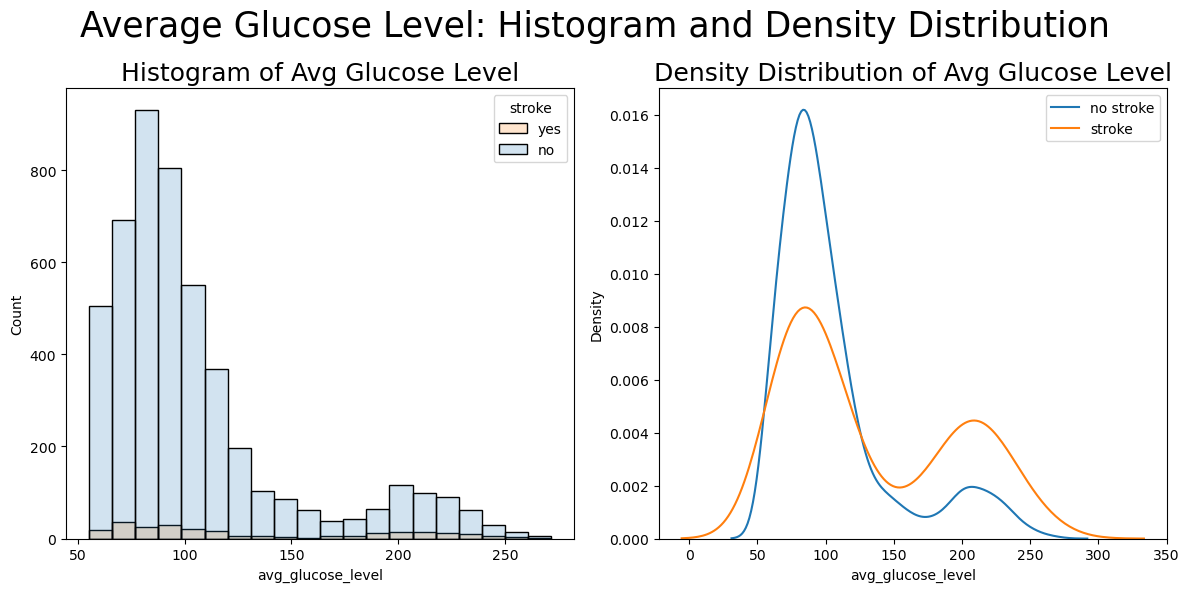

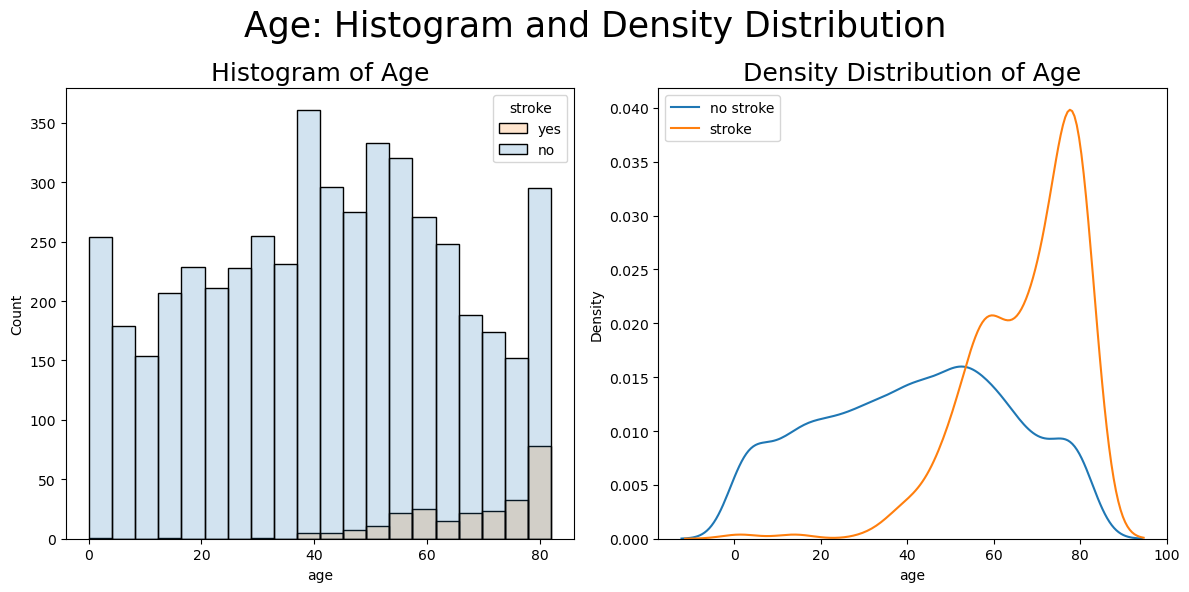

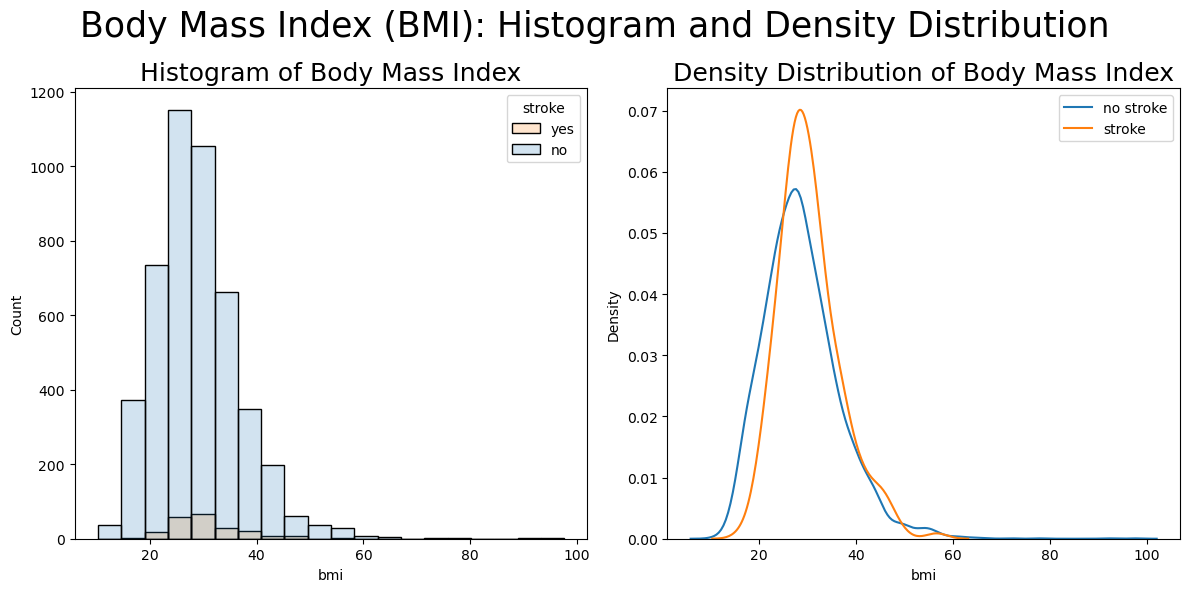

In [61]:
### Figures ###
bigfig = plt.figure(figsize=(12,6))

(top, central, bottom) = bigfig.subfigures(3,1)

### Top figure ###
top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(data=data, x='avg_glucose_level', hue='stroke', bins=20, alpha=0.2, ax=ax1)
ax1.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax1.set_title('Histogram of Avg Glucose Level', size=18)

ax2 = sns.kdeplot(data=data.loc[data.stroke == 0], x='avg_glucose_level', label='no stroke', ax=ax2)
ax2 = sns.kdeplot(data=data.loc[data.stroke == 1], x='avg_glucose_level', label='stroke', ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Density Distribution of Avg Glucose Level', size=18)

plt.suptitle('Average Glucose Level: Histogram and Density Distribution', size=25)

plt.tight_layout()

### Central figure ###
central.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(data=data, x='age', hue='stroke', bins=20, alpha=0.2, ax=ax1)
ax1.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax1.set_title('Histogram of Age', size=18)

ax2 = sns.kdeplot(data=data.loc[data.stroke == 0], x='age', label='no stroke', ax=ax2)
ax2 = sns.kdeplot(data=data.loc[data.stroke == 1], x='age', label='stroke', ax=ax2)
ax2.legend(loc='upper left')
ax2.set_title('Density Distribution of Age', size=18)

plt.suptitle('Age: Histogram and Density Distribution', size=25)

plt.tight_layout()

### Bottom figure ###
bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(data=data, x='bmi', hue='stroke', bins=20, alpha=0.2, ax=ax1)
ax1.legend(title='stroke', loc='upper right', labels=['yes', 'no'])
ax1.set_title('Histogram of Body Mass Index', size=18)

ax2 = sns.kdeplot(data=data.loc[data.stroke == 0], x='bmi', label='no stroke', ax=ax2)
ax2 = sns.kdeplot(data=data.loc[data.stroke == 1], x='bmi', label='stroke', ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Density Distribution of Body Mass Index', size=18)

plt.suptitle('Body Mass Index (BMI): Histogram and Density Distribution', size=25)

plt.tight_layout()

It is worth to note that:

- The average glucose level distributions of stroke vs non-stroke cases are quite different. In particular, the secondary peak at around 200-220 glucose level is higher in the case of stroke cases.
- As expected the age distributions of stroke vs non-stroke cases are very different. Strokes are rare at young ages and are more frequent in older people.

In [64]:
data.drop(['has_stroke', 'has_hypertension', 'has_heart_disease'], axis=1, inplace=True)

## 2.2 'Original' Dataset vs 'No Nulls' Dataset¶

In this section, I will compare the variable distributions from the 'original' dataset and the dataset where the rows with null values were dropped. I will be doing this to see if removing the rows with null 'bmi' values could affect the other variable distributions or not.

In [96]:
data_no_nulls = data.dropna(axis=0)

num_columns = [col for col in data.columns if (data[col].dtypes != 'O') & (col not in ['id', 'bmi'])]

print(f'feature             mean (w/ nulls)             mean (no nulls)             rel. difference (%)\n')
def compare_mean(data, data_nn):
    for col in num_columns:
        print('{:20s} {:8.3f} {:28.3f} {:30.1f}'.format(col, data[col].mean(), data_nn[col].mean(), abs(data[col].mean() - data_nn[col].mean()) / data[col].mean() * 100))

compare_mean(data, data_no_nulls)        

feature             mean (w/ nulls)             mean (no nulls)             rel. difference (%)

age                    43.227                       42.865                            0.8
hypertension            0.097                        0.092                            5.7
heart_disease           0.054                        0.050                            8.4
avg_glucose_level     106.148                      105.305                            0.8
stroke                  0.049                        0.043                           12.6


One can notice that removing the rows with the null values would have a relatively large impact on the distributions of the other variables (in particular 'stroke', 'hypertension' and 'heart_disease').

Let's have a look at 'strokes'. Let's compare the relative difference in the number of stroke events before and after null rows dropping and compare it to the corresponding relative difference between the dataset lengths before and after null rows dropping. The two fractions should be similar.

In [100]:
print(f"Stroke events: {data['stroke'].value_counts()[1]} (w/ nulls), {data_no_nulls['stroke'].value_counts()[1]} (no nulls).")

print(f"Relative difference in the number of strokes = {(data['stroke'].value_counts()[1] - data_no_nulls['stroke'].value_counts()[1]) / data['stroke'].value_counts()[1] * 100:.0f}%")

print(f"Relative difference in the dataset length = {(len(data) - len(data_no_nulls)) / len(data) * 100:.0f}%")

Stroke events: 249 (w/ nulls), 209 (no nulls).
Relative difference in the number of strokes = 16%
Relative difference in the dataset length = 4%


The two percentages are very different. This means that dropping the rows with null values of 'bmi' would change the proportion of stroke to non-stroke events in the data. This is why the null values of 'bmi' must be imputed.

## 2.3 Outliers

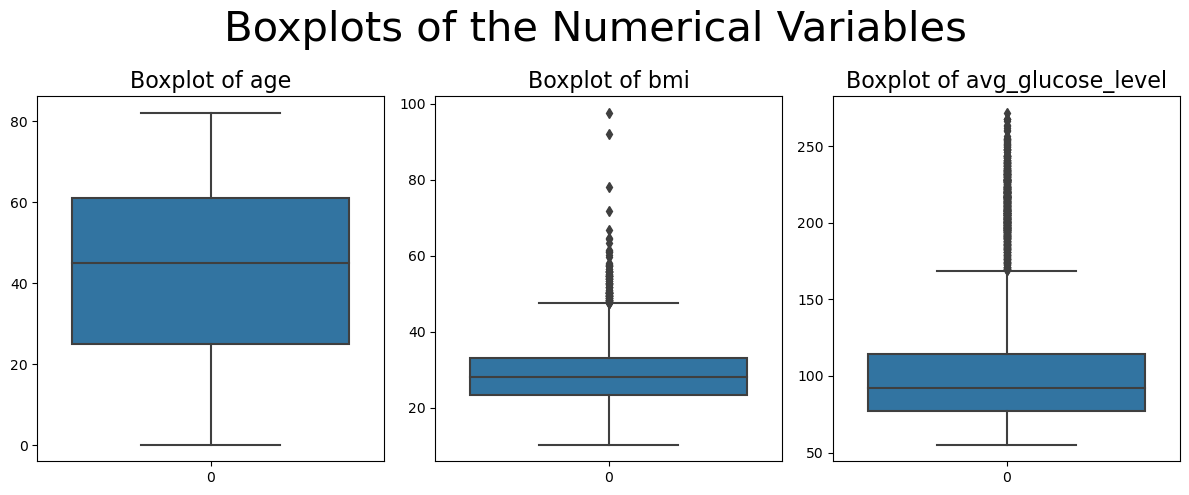

In [104]:
num_features = ['age', 'bmi', 'avg_glucose_level']

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,5))

ax1 = sns.boxplot(data[num_features[0]],ax=ax1)
ax1.set_title('Boxplot of '+str(num_features[0]),fontsize=16)

ax2 = sns.boxplot(data[num_features[1]],ax=ax2)
ax2.set_title('Boxplot of '+str(num_features[1]),fontsize=16)

ax3 = sns.boxplot(data[num_features[2]],ax=ax3)
ax3.set_title('Boxplot of '+str(num_features[2]),fontsize=16)

plt.suptitle('Boxplots of the Numerical Variables',size=30)

plt.tight_layout()

There are outliers both in the 'bmi' and 'avg_glucose_level' columns. Let's see what is their fraction with respect to the total number of values in their columns.

In [107]:
outliers_perc = []

def outliers_perc_search(data, num_features):
    for k,v in data[num_features].items():
        # Column must be of numeric type (not object)
        if data[k].dtype != 'O':
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
            out_tuple = (k,int(perc))
            outliers_perc.append(out_tuple)
            print("Column %s outliers = %.1f%%" % (k,perc))

outliers_perc_search(data, num_features)

Column age outliers = 0.0%
Column bmi outliers = 2.2%
Column avg_glucose_level outliers = 12.3%


One of the fractions (that of 'avg_glucose_level') is quite large. Therefore dropping the outliers might not be the best option.

Later, I will explore two different possibilities:

1. Use a Box-Cox transformation to make the distributions more bell-shaped.
2. Use a tree-based classifier (like random forest or gradient boosting), that is naturally robust to outliers.

# 3. Data Preprocessing

## 3.1 Outliers Imputation

In [112]:
capped_cols = ['bmi', 'avg_glucose_level']

def remove_outliers_iqr(data, column):

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data


for col in capped_cols:
    data = remove_outliers_iqr(data, col)

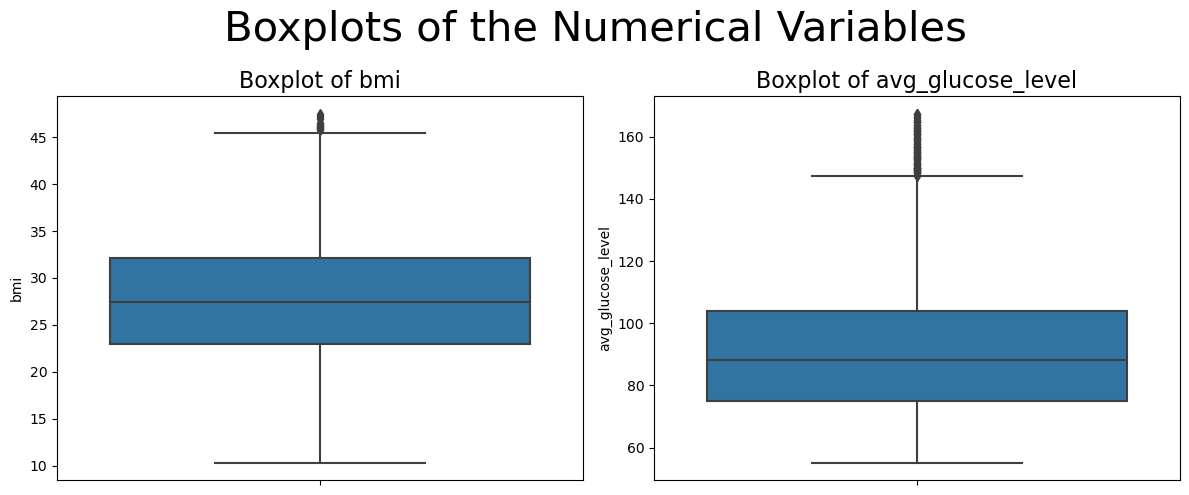

In [114]:
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax1 = sns.boxplot(y=data[capped_cols[0]],ax=ax1)
ax1.set_title('Boxplot of '+str(capped_cols[0]),fontsize=16)

ax2 = sns.boxplot(y=data[capped_cols[1]],ax=ax2)
ax2.set_title('Boxplot of '+str(capped_cols[1]),fontsize=16)

plt.suptitle('Boxplots of the Numerical Variables',size=30)

plt.tight_layout()

## 3.2 Train-Test Split

First of all, I am shuffling the data and then performing train-test split.

In [118]:
data = data.sample(frac=1, random_state=42) 

X = data.drop(['stroke', 'id'], axis=1)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 3.3 Imputation of the Null Values of 'bmi'

I am imputing the null values of 'bmi' with the average values of 'bmi' calculated for 'stroke' = 0 and 1. The means are calculated on the train set values only.

First, I am creating lists with the indices of 'stroke' = 0 and 1 events for both the train and test datasets.

In [122]:
train_stroke_index = y_train[y_train == 0].index.to_list()
train_no_stroke_index = y_train[y_train == 1].index.to_list()

test_stroke_index = y_test[y_test == 0].index.to_list()
test_no_stroke_index = y_test[y_test == 1].index.to_list()

I also want to create a column that highlights which values were originally missing. In some cases, this will help the model to improve its predictions. In other cases, it will not help at all. I will find out at the classification stage.

In [125]:
X_train['bmi_was_missing'] = ''
X_test['bmi_was_missing']  = ''

X_train.loc[(X_train['bmi'].isna()), 'bmi_was_missing'] = 'yes'
X_train.loc[~X_train['bmi'].isna(), 'bmi_was_missing'] = 'no'

X_test.loc[(X_test['bmi'].isna()), 'bmi_was_missing'] = 'yes'
X_test.loc[~X_test['bmi'].isna(), 'bmi_was_missing'] = 'no'

Finally, I can impute the nulls with the two means.

In [144]:
bmi_stroke_mean = X_train.loc[train_stroke_index]['bmi'].mean()
bmi_no_stroke_mean = X_train.loc[train_no_stroke_index]['bmi'].mean()

X_train.loc[(X_train['bmi'].isna()) & (X_train.index.isin(train_stroke_index)), 'bmi'] = bmi_stroke_mean
X_train.loc[(X_train['bmi'].isna()) & (X_train.index.isin(train_no_stroke_index)), 'bmi'] = bmi_no_stroke_mean

X_test.loc[(X_test['bmi'].isna()) & (X_test.index.isin(test_stroke_index)), 'bmi'] = bmi_stroke_mean
X_test.loc[(X_test['bmi'].isna()) & (X_test.index.isin(test_no_stroke_index)), 'bmi'] = bmi_no_stroke_mean

## 3.4 Encoding the Categorical Variables¶

The first step is to check that the training data contains values that also appear in the test data. If this is not the case, then encoding can result in errors.

In [148]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_was_missing']

Categorical columns that will be dropped from the dataset: []


I may have problems with the columns 'work_type'. I can either drop the column or set "handle_unknown = 'ignore'" in sklearn's OneHotEncoder.

I can now proceed with the encoding. The variables to encode are:

- gender (3 categories)
- ever_married (binary)
- work_type (5 categories)
- Residence_type (binary)
- smoking_status (4 categories)
- bmi_was_missing (binary)

In [151]:
### Label encoding ###
LE_cols = ['ever_married', 'Residence_type', 'bmi_was_missing', 'gender']

encoder1 = LabelEncoder()

for col in LE_cols:
    X_train[col] = encoder1.fit_transform(X_train[col])
    X_test[col]  = encoder1.transform(X_test[col])   

In [153]:
### One-hot encoding ###
OHE_cols = ['work_type', 'smoking_status'] 

#encoder2 = OneHotEncoder(handle_unknown='ignore')
encoder2 = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform="pandas")

# Fit and transform the categorical columns
OHE_train = pd.DataFrame(encoder2.fit_transform(X_train[OHE_cols]))
OHE_test  = pd.DataFrame(encoder2.transform(X_test[OHE_cols]))

# One-hot encoding removed index; put it back
OHE_train.index = X_train.index
OHE_test.index  = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = X_train.drop(OHE_cols, axis=1)
num_test  = X_test.drop(OHE_cols, axis=1)

# Add one-hot encoded columns to numerical features
OHE_X_train = pd.concat([num_train, OHE_train], axis=1)
OHE_X_test  = pd.concat([num_test, OHE_test], axis=1) 

## 3.5 Feature Scaling

In [156]:
scaler = StandardScaler()

OHE_X_train[['age', 'bmi', 'avg_glucose_level']] = scaler.fit_transform(OHE_X_train[['age', 'bmi', 'avg_glucose_level']])
OHE_X_test[['age', 'bmi', 'avg_glucose_level']]  = scaler.transform(OHE_X_test[['age', 'bmi', 'avg_glucose_level']])

OHE_X_train.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,bmi_was_missing,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3262,1,0.275869,0,0,1,0,-0.127271,-0.839968,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2312,0,1.566954,0,0,1,1,0.841900,0.600979,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3813,1,0.053268,0,0,1,0,-1.042100,0.630999,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1835,0,0.498470,0,1,1,1,-0.254368,1.741730,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3190,0,0.498470,0,0,1,1,0.683366,-0.809949,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3.6 Resampling the Training Dataset

The train data may have to be resampled because it is imbalanced: the target classes are not present in a similar proportion.

In [160]:
# Create a RandomUnderSampler object
#rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')

# Undersampler object
#X_resampled, y_resampled = rus.fit_resample(OHE_X_train, y_train)

# OverSampler object
ros = SMOTE(random_state=42, sampling_strategy='minority')

X_resampled, y_resampled = ros.fit_resample(OHE_X_train, y_train)

X_resampled.shape, y_resampled.shape, X_train.shape, y_train.shape

((5768, 18), (5768,), (2979, 11), (2979,))

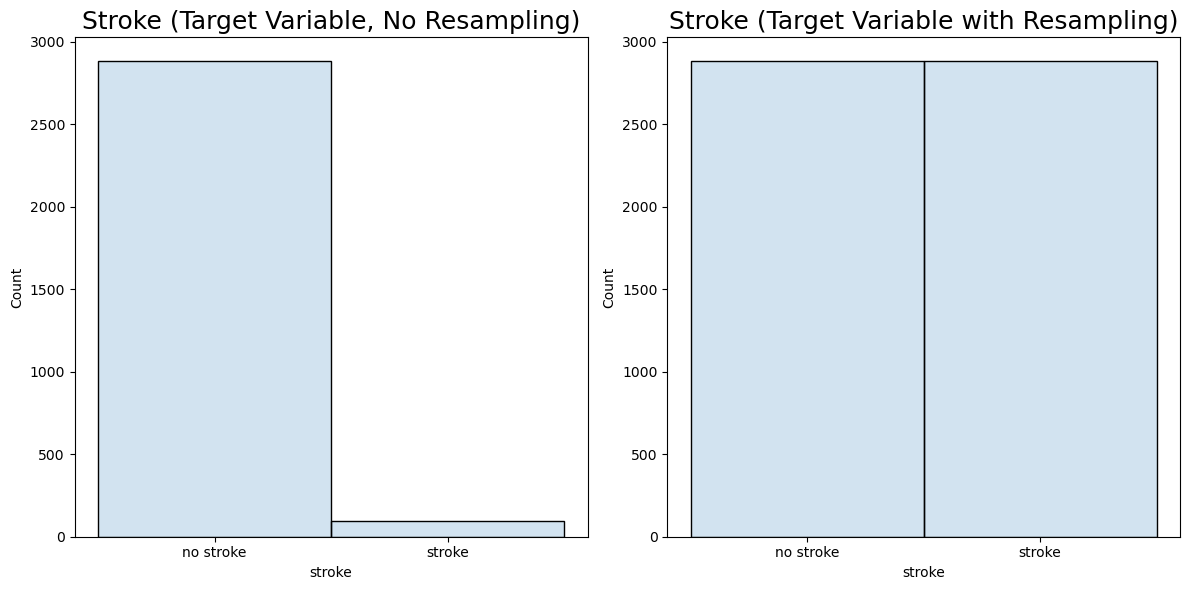

In [162]:
y_train_has_stroke     = y_train.map(has_stroke)
y_resampled_has_stroke = y_resampled.map(has_stroke)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(data=y_train_has_stroke, alpha=0.2, ax=ax1)
ax1.set_title('Stroke (Target Variable, No Resampling)', size=18)

ax2 = sns.histplot(data=y_resampled_has_stroke, alpha=0.2, ax=ax2)
ax2.set_title('Stroke (Target Variable with Resampling)', size=18)

plt.tight_layout()

In [ ]:
3.7 Correlations Between Numerical Variables¶